# Example analysis of Montage Workflow

## Package imports

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import requests
from requests.auth import HTTPBasicAuth
import seaborn as sns
import numpy as np

## Data imports - from file

In [1]:
logs_file = 'log_file_path'
metrics_file = 'metric_file_path'

with open(metrics_file, 'r') as f1:
    metrics = json.load(f1)

with open(logs_file, 'r') as f:
    logs = json.load(f)

metrics_df = pd.DataFrame(metrics)
logs_df = pd.DataFrame(logs)

print(f"Metrics: {metrics_df.shape}")
print(f"Logs: {logs_df.shape}")


Metrics: (3851529, 41)
Logs: (176499, 35)


## Data imports - directly from API

In [ ]:
# === CONFIG ===
BASE_URL = "http://127.0.0.1:8000"
USERNAME = "admin"
PASSWORD = "Hyperflow1!"

START_DATE = "2025-06-15T01:10:00Z"
END_DATE   = "2025-06-15T15:30:59Z"

def load_jsonl_stream(endpoint: str, params: dict) -> list:
    url = f"{BASE_URL}{endpoint}"
    auth = HTTPBasicAuth(USERNAME, PASSWORD)

    # DEBUG: show the url
    prepared = requests.Request('GET', url, params=params, auth=auth).prepare()
    # print("🔗 FINAL REQUEST URL:", prepared.url)

    data = []
    with requests.Session() as session:
        response = session.send(prepared, stream=True)
        print("📡 Status:", response.status_code)
        response.raise_for_status()
        for line in response.iter_lines():
            if line:
                data.append(json.loads(line))
    return data

logs = load_jsonl_stream("/logs/by-date/stream", {
    "start_date": START_DATE,
    "end_date": END_DATE
})

metrics = load_jsonl_stream("/metrics/by-date/stream", {
    "start_date": START_DATE,
    "end_date": END_DATE
})

logs_df = pd.DataFrame(logs)
metrics_df = pd.DataFrame(metrics)

# === INFO ===
print(f"✅ Logs loaded: {logs_df.shape}")
print(f"✅ Metrics loaded: {metrics_df.shape}")


# Workflow execution time

In [3]:
workflow_end_log = logs_df[logs_df['body'].str.contains('Workflow finished', na=False)]

workflow_end_time = pd.to_datetime(workflow_end_log['time'].values[0], utc=True, errors='coerce')
workflow_duration_seconds = workflow_end_log['log.attributes.timeInSeconds'].values[0]
workflow_duration_minutes = workflow_duration_seconds / 60 
print(f"Workflow makespan [m]: {workflow_duration_minutes:.2f} minutes")
print(f"Workflow makespan [s]: {workflow_duration_seconds:.0f} seconds")

Workflow makespan [m]: 32.34 minutes
Workflow makespan [s]: 1940 seconds


# Workflow timeline

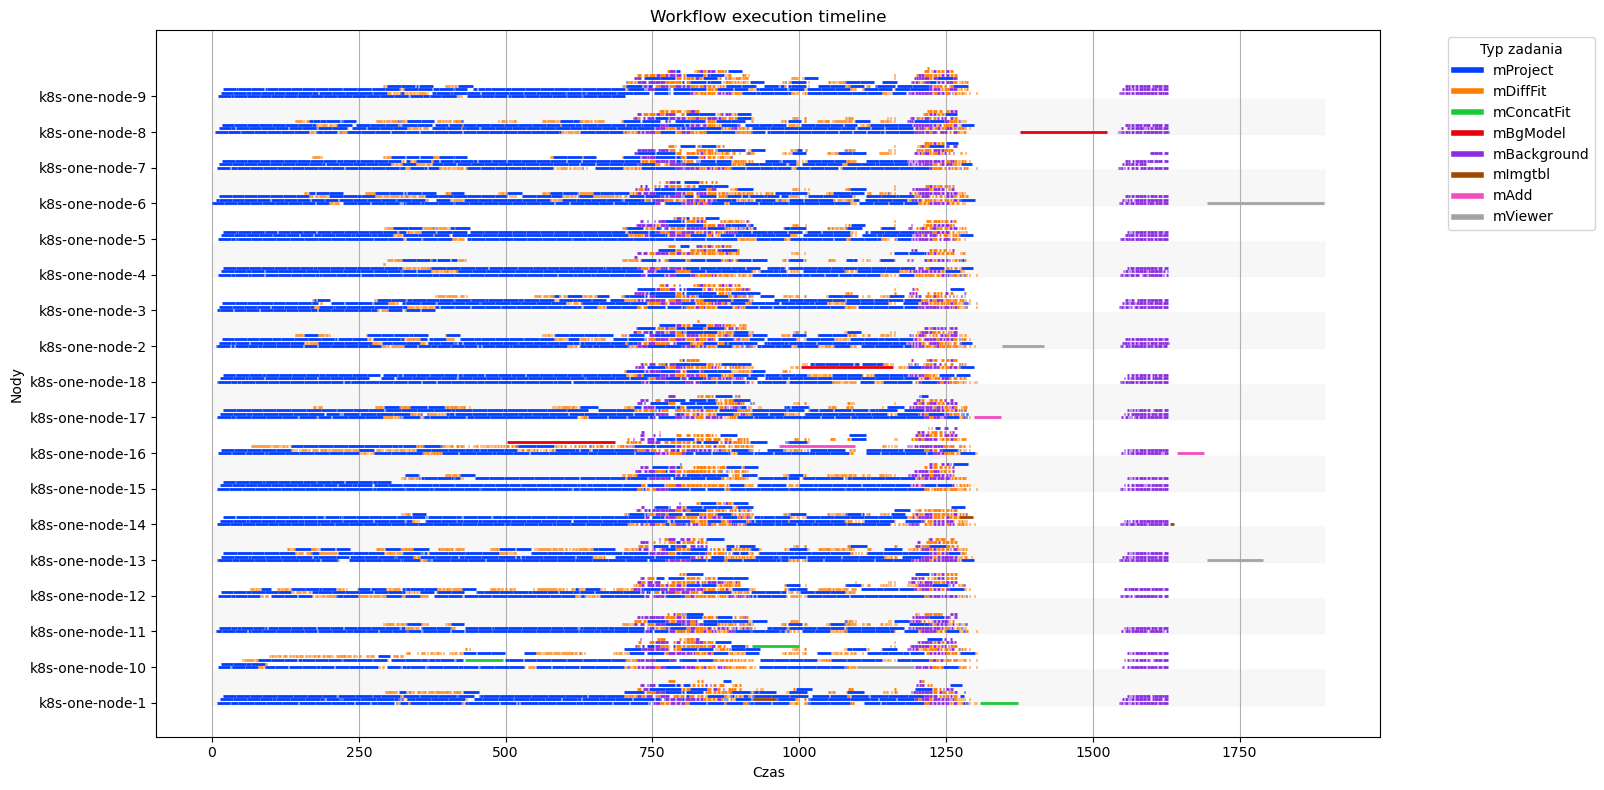

In [34]:
started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time', 'log.attributes.name']]
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']]

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end'))
jobs['duration'] = (jobs['time_end'] - jobs['time_start']).dt.total_seconds()

workflow_start = jobs['time_start'].min()
jobs['time_start_seconds'] = (jobs['time_start'] - workflow_start).dt.total_seconds()
jobs['time_end_seconds'] = (jobs['time_end'] - workflow_start).dt.total_seconds()

job_nodes = logs_df[logs_df['body'] == 'Job description'][['log.attributes.jobId', 'log.attributes.nodeName']].drop_duplicates()
job_nodes = job_nodes.rename(columns={'log.attributes.jobId': 'jobId', 'log.attributes.nodeName': 'nodeName'})
jobs = pd.merge(jobs, job_nodes, left_on='log.attributes.jobId', right_on='jobId', how='left')
jobs['nodeName'] = jobs['nodeName'].fillna('unknown')

unique_nodes = sorted(jobs['nodeName'].unique())
node_to_y = dict(zip(unique_nodes, range(len(unique_nodes))))
jobs['node_y'] = jobs['nodeName'].map(node_to_y)

unique_job_types = jobs['log.attributes.name'].unique()
palette = sns.color_palette("bright", len(unique_job_types))
job_type_to_color = dict(zip(unique_job_types, palette))

jobs['slot_in_node'] = 0

for node in unique_nodes:
    node_jobs = jobs[jobs['nodeName'] == node].sort_values('time_start_seconds').copy()
    slots = []

    for idx, row in node_jobs.iterrows():
        placed = False
        for slot_num, end_time in enumerate(slots):
            if row['time_start_seconds'] >= end_time:
                slots[slot_num] = row['time_end_seconds']
                jobs.loc[idx, 'slot_in_node'] = slot_num
                placed = True
                break
        if not placed:
            slots.append(row['time_end_seconds'])
            jobs.loc[idx, 'slot_in_node'] = len(slots) - 1

jobs['plot_y'] = jobs['node_y'] * 10 + jobs['slot_in_node']

plt.figure(figsize=(14, 8))

for node_name, y in node_to_y.items():
    y_min = y * 10 - 0.5
    y_max = (y + 1) * 10 - 0.5
    color = '#f0f0f0' if y % 2 == 0 else '#ffffff'
    plt.fill_betweenx([y_min, y_max], 0, jobs['time_end_seconds'].max(), color=color, alpha=0.5)

for _, row in jobs.iterrows():
    job_type = row['log.attributes.name']
    color = job_type_to_color[job_type]
    plt.hlines(row['plot_y'], row['time_start_seconds'], row['time_end_seconds'], color=color, linewidth=2)

plt.xlabel('Czas')
plt.ylabel('Nody')
plt.title('Workflow execution timeline')
plt.grid(axis='x')
yticks = [y * 10 for y in node_to_y.values()]
plt.yticks(yticks, list(node_to_y.keys()))
plt.tight_layout()
handles = [plt.Line2D([0], [0], color=job_type_to_color[job_type], lw=4, label=job_type) for job_type in unique_job_types]
plt.legend(handles=handles, title='Typ zadania', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Number of active jobs

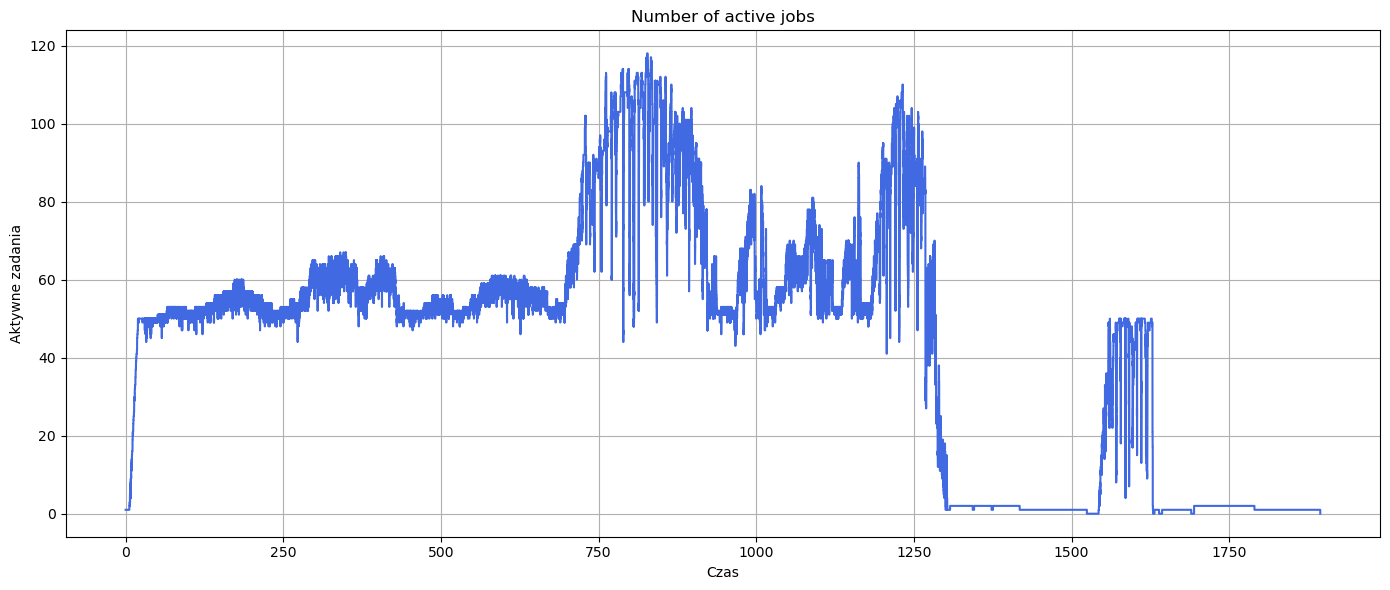

In [35]:
started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time']]
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']]

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs2 = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end')).dropna()

jobs2['duration'] = (jobs2['time_end'] - jobs2['time_start']).dt.total_seconds()

events = []
for _, row in jobs2.iterrows():
    events.append((row['time_start'], 1))
    events.append((row['time_end'], -1)) 

events_df = pd.DataFrame(events, columns=['time', 'change'])

events_df = events_df.dropna(subset=['time'])

events_df['sort_order'] = events_df['change'] * -1 
events_df = events_df.sort_values(['time', 'sort_order']).reset_index(drop=True)

workflow_start_time = events_df['time'].min()
events_df['time_seconds'] = (events_df['time'] - workflow_start_time).dt.total_seconds()

events_df['active_jobs'] = events_df['change'].cumsum()

plt.figure(figsize=(14, 6))
plt.step(events_df['time_seconds'], events_df['active_jobs'], where='post', color='royalblue')
plt.xlabel('Czas')
plt.ylabel('Aktywne zadania')
plt.title('Number of active jobs')
plt.grid(True)
plt.tight_layout()
plt.show()


## Job exection time - by job type 
### Statistics

In [ ]:
grouped_stats = jobs.groupby('log.attributes.name')['duration'].agg([
    ('Mean time (s)', 'mean'),
    ('Min time (s)', 'min'),
    ('Max time (s)', 'max'),
    ('Job count', 'count'),
    ('P10 (s)', lambda x: x.quantile(0.10)),
    ('P25 (s)', lambda x: x.quantile(0.25)),
    ('P50 (s)', lambda x: x.quantile(0.50)),
    ('P90 (s)', lambda x: x.quantile(0.90)),
    ('P99 (s)', lambda x: x.quantile(0.99)),
])

print(grouped_stats)

                     Mean time (s)  Min time (s)  Max time (s)  Job count  \
log.attributes.name                                                         
mAdd                     73.811333        44.760       130.477          3   
mBackground               4.980917         0.533        12.400       2095   
mBgModel                163.368333       148.832       184.550          3   
mConcatFit               70.362333        64.492        80.842          3   
mDiffFit                  1.508095         0.090        14.738       9651   
mImgtbl                  23.287333         7.265        39.550          3   
mProject                 12.653758         0.163        36.549       4659   
mViewer                 116.187250        72.246       200.067          4   

                      P10 (s)   P25 (s)  P50 (s)   P90 (s)    P99 (s)  
log.attributes.name                                                    
mAdd                  45.0474   45.4785   46.197  113.6210  128.79140  
mBackground  

### Histogram

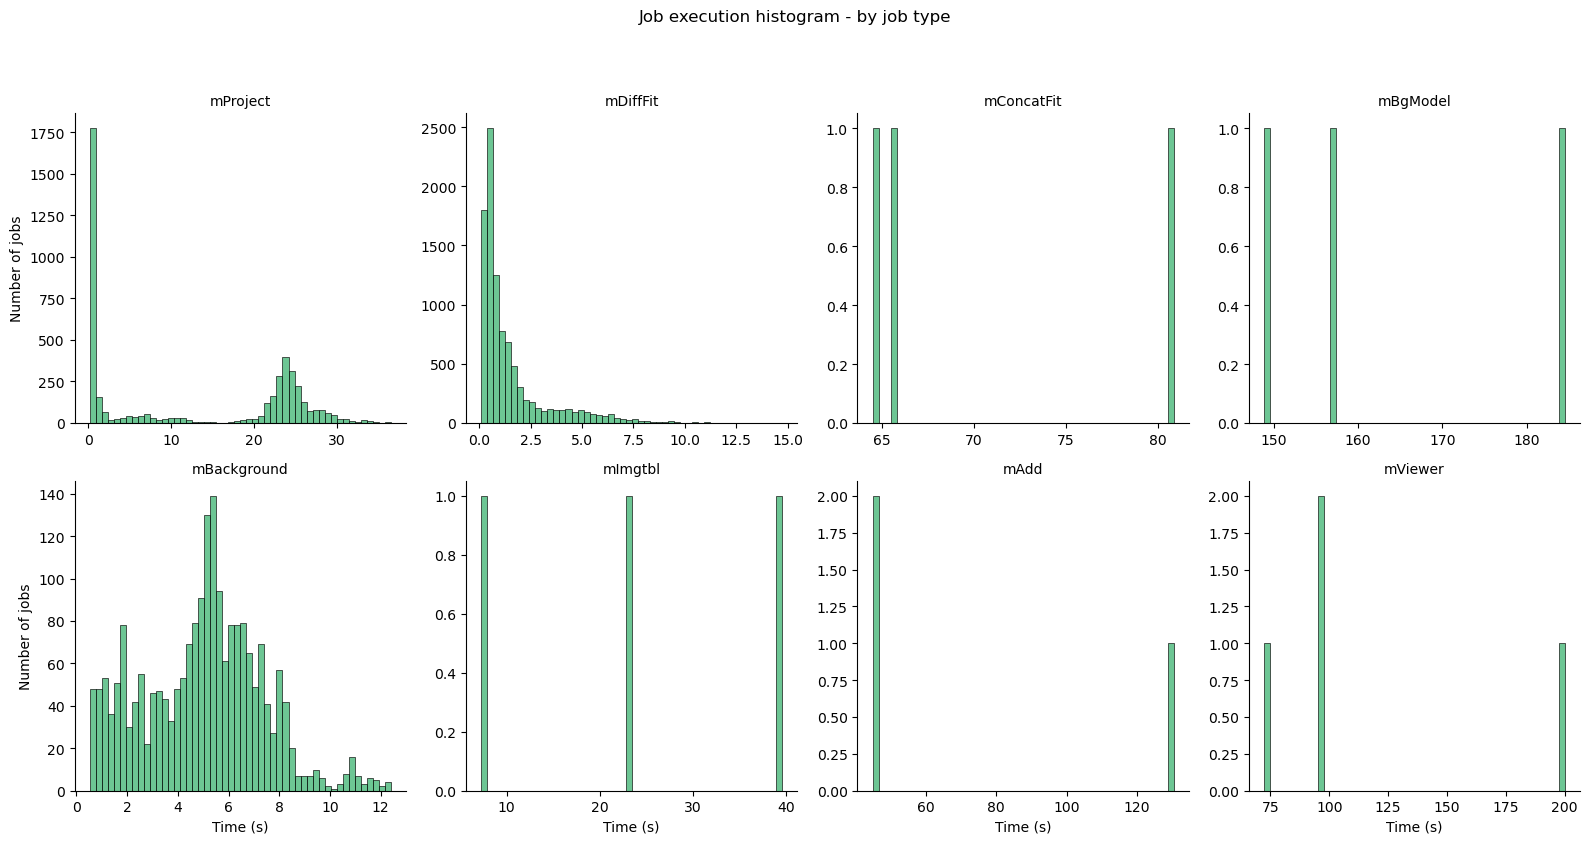

In [37]:
started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time', 'log.attributes.name']]
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']]

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end'))
jobs['duration'] = (jobs['time_end'] - jobs['time_start']).dt.total_seconds()

jobs = jobs.dropna(subset=['log.attributes.name'])

g = sns.FacetGrid(jobs, col="log.attributes.name", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="duration", color='mediumseagreen', bins=50)

g.set_axis_labels("Time (s)", "Number of jobs")
g.set_titles(col_template="{col_name}")

plt.suptitle("Job execution histogram - by job type", y=1.05)
plt.tight_layout()
plt.show()


### Box plot

/var/folders/1c/3gp0dxs11_jbqbhcxmdbmf400000gn/T/ipykernel_37199/4120245199.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=jobs_duration, x='log.attributes.name', y='duration', palette='Set1', showfliers=False)


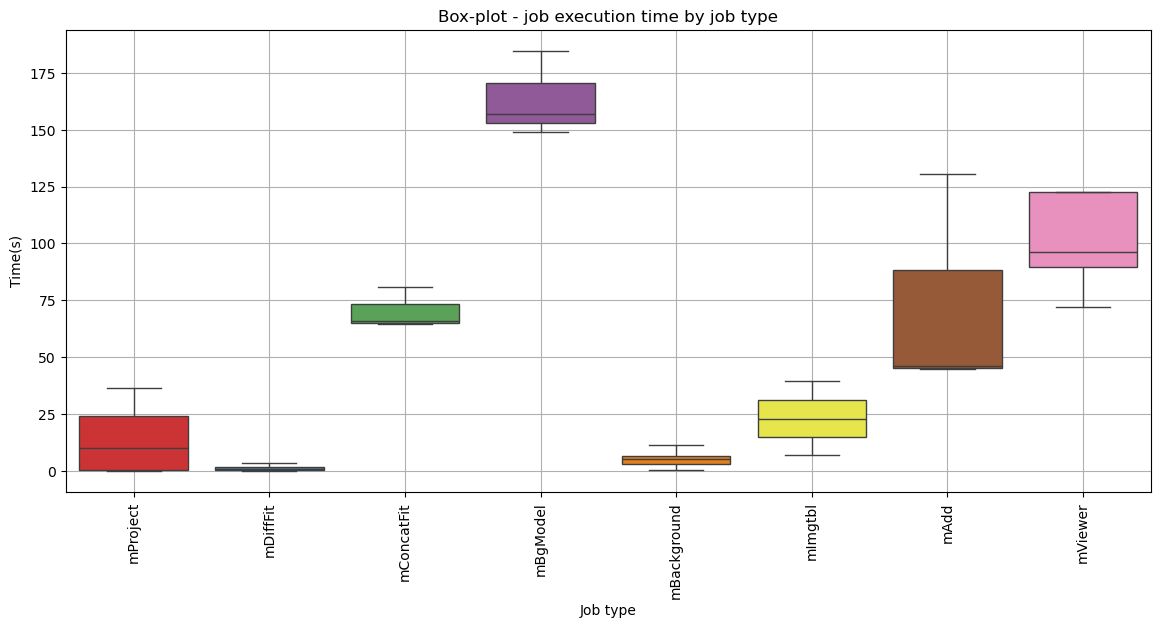

In [39]:
jobs_duration = jobs.copy()
plt.figure(figsize=(14, 6))
sns.boxplot(data=jobs_duration, x='log.attributes.name', y='duration', palette='Set1', showfliers=False)
plt.title("Box-plot - job execution time by job type")
plt.xlabel("Job type")
# plt.yscale('log') -> set y axis to log scale 
plt.ylabel("Time(s)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show() 

## CPU
### Statistics

In [16]:
cpu_df = metrics_df[metrics_df['name'] == 'cpu-usage'].copy()

job_names = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()
cpu_df = cpu_df.merge(job_names, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

cpu_per_job = cpu_df.groupby(['metric.attributes.jobId', 'log.attributes.name'])['value'].mean().reset_index()
cpu_per_job.rename(columns={'value': 'avg_cpu'}, inplace=True)

cpu_grouped_stats = cpu_per_job.groupby('log.attributes.name')['avg_cpu'].agg([
    ('Mean CPU (%)', 'mean'),
    ('Min CPU (%)', 'min'),
    ('Max CPU (%)', 'max'),
    ('Job count', 'count'),
    ('P10 CPU (%)', lambda x: x.quantile(0.10)),
    ('P25 CPU (%)', lambda x: x.quantile(0.25)),
    ('P50 CPU (%)', lambda x: x.quantile(0.50)),
    ('P90 CPU (%)', lambda x: x.quantile(0.90)),
    ('P99 CPU (%)', lambda x: x.quantile(0.99))
])

print(cpu_grouped_stats)

                     Mean CPU (%)  Min CPU (%)  Max CPU (%)  Job count  \
log.attributes.name                                                      
mAdd                    57.593709    32.381978    70.388001          3   
mBackground              8.439118     0.000000   166.666667       1954   
mBgModel                98.456062    96.573772    99.920787          3   
mConcatFit              59.034424    51.911969    63.495832          3   
mDiffFit                 2.161897     0.000000   100.000000       4054   
mImgtbl                 28.347176    13.167329    53.220231          3   
mProject                77.492907     0.000000   767.281500       2999   
mViewer                 90.759381    87.714384    94.335499          4   

                     P10 CPU (%)  P25 CPU (%)  P50 CPU (%)  P90 CPU (%)  \
log.attributes.name                                                       
mAdd                   39.907812    51.196563    70.011149    70.312630   
mBackground             0.518504  

### Histigram

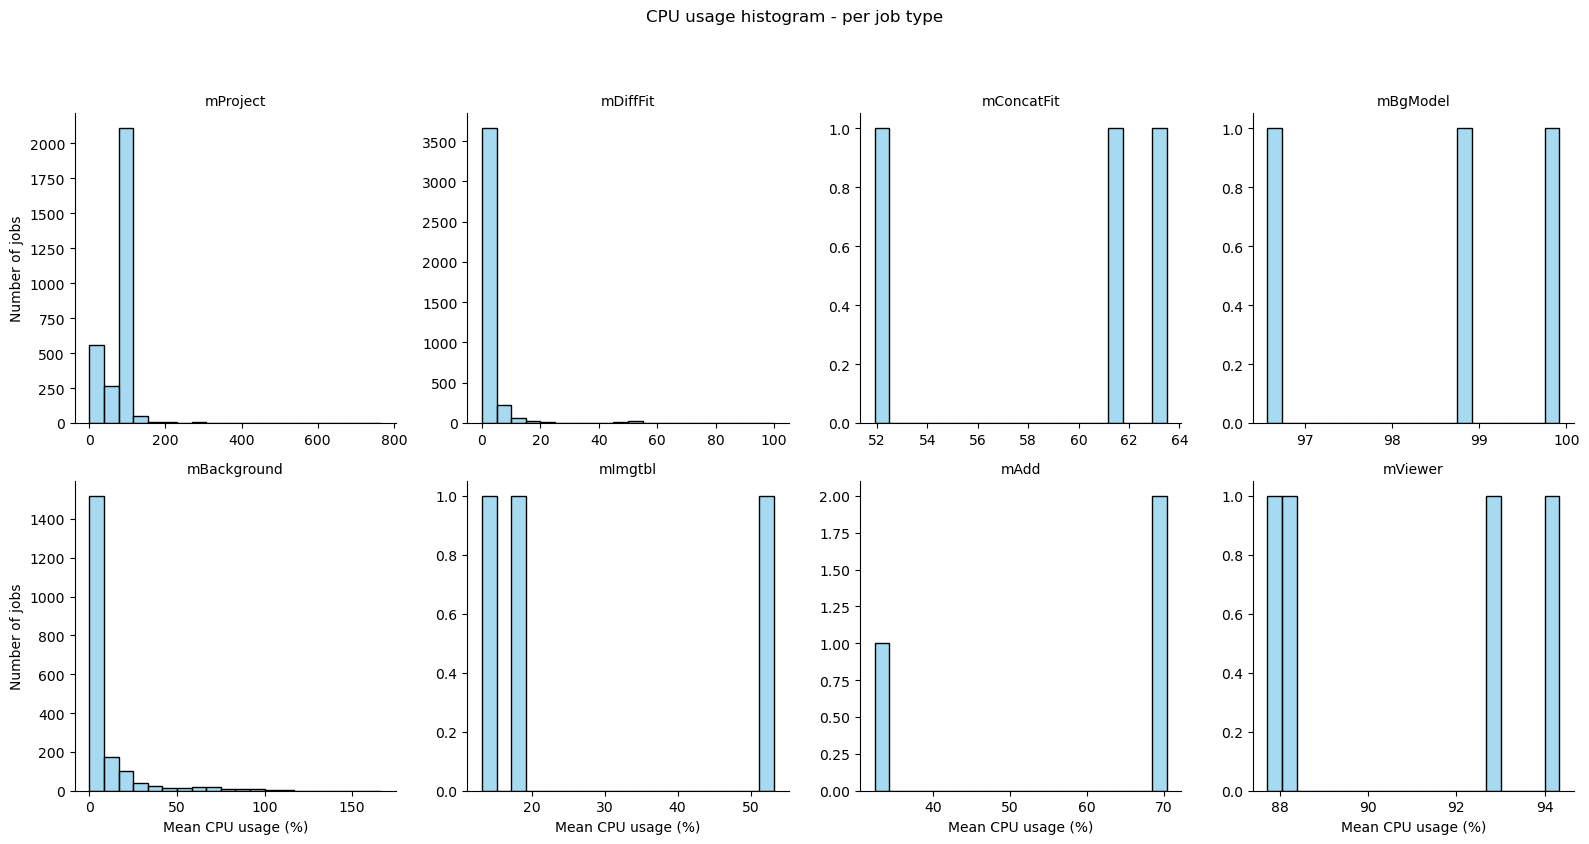

In [40]:
cpu_df = metrics_df[metrics_df['name'] == 'cpu-usage'].copy()
cpu_df['time'] = pd.to_datetime(cpu_df['time'], utc=True, errors='coerce')

job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()
cpu_df = cpu_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

cpu_per_job = cpu_df.groupby(['metric.attributes.jobId', 'log.attributes.name'])['value'].mean().reset_index()
cpu_per_job.rename(columns={'value': 'avg_cpu'}, inplace=True)

g = sns.FacetGrid(cpu_per_job, col="log.attributes.name", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="avg_cpu", color='skyblue', bins=20)
g.set_axis_labels("Mean CPU usage (%)", "Number of jobs")
g.set_titles(col_template="{col_name}")
plt.suptitle("CPU usage histogram - per job type", y=1.05)
plt.tight_layout()
plt.show()


### Total of CPU usage in time

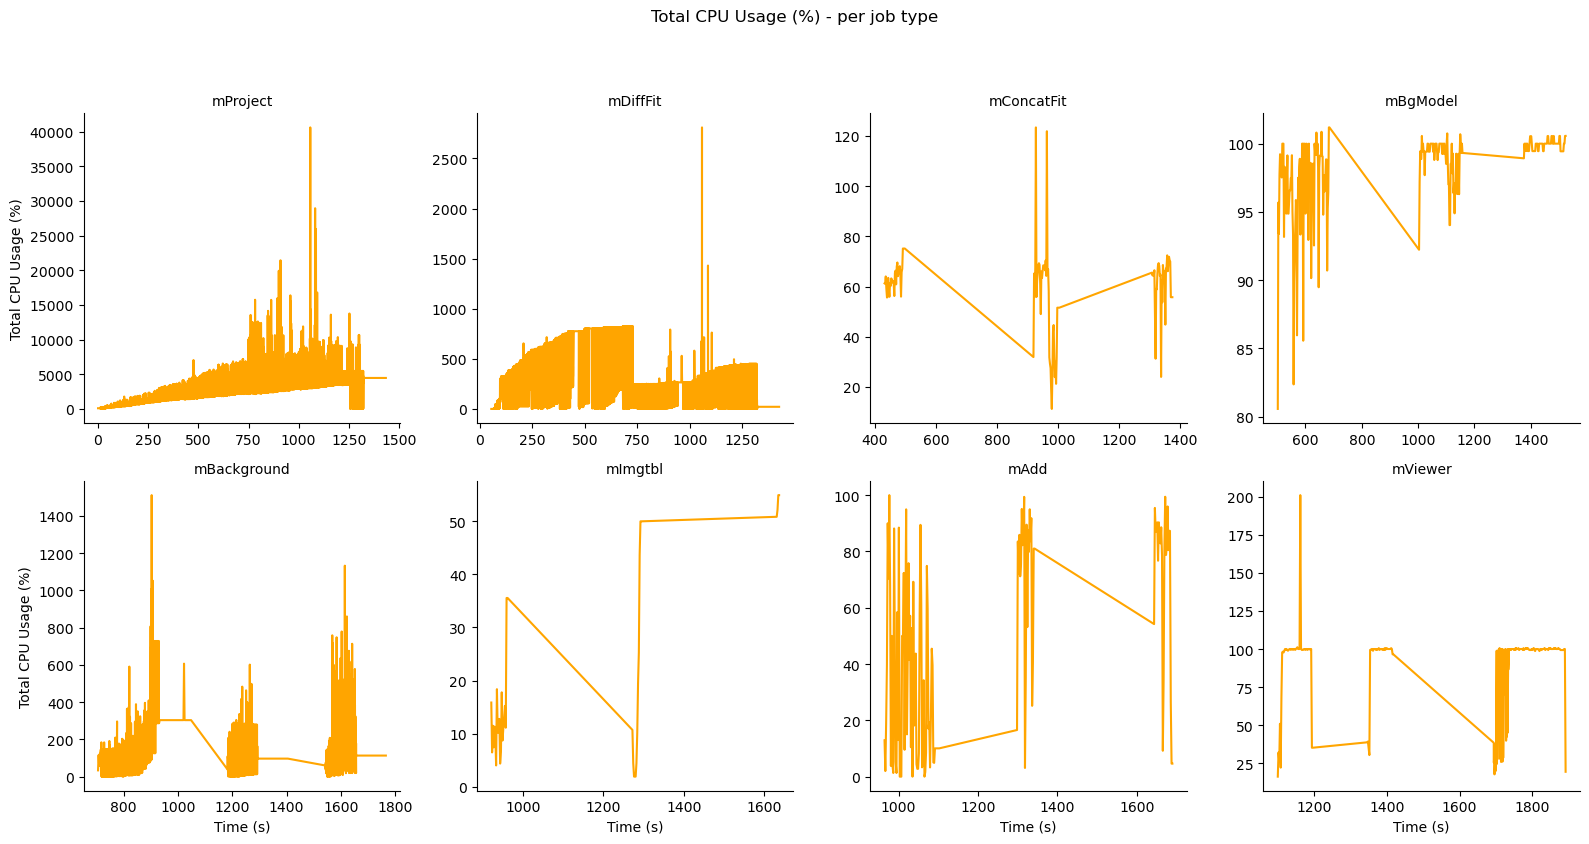

In [41]:
cpu_df = metrics_df[metrics_df['name'] == 'cpu-usage'].copy()
cpu_df['time'] = pd.to_datetime(cpu_df['time'], utc=True, errors='coerce')

job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()
cpu_df = cpu_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

cpu_grouped = cpu_df.groupby(['time', 'log.attributes.name'])['value'].sum().reset_index()

cpu_start = cpu_grouped['time'].min()
cpu_grouped['time_seconds'] = (cpu_grouped['time'] - cpu_start).dt.total_seconds()

g = sns.FacetGrid(cpu_grouped, col="log.attributes.name", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="time_seconds", y="value", color='orange')
g.set_axis_labels("Time (s)", "Total CPU Usage (%)")
g.set_titles(col_template="{col_name}")
plt.suptitle("Total CPU Usage (%) - per job type", y=1.05)
plt.tight_layout()
plt.show()


### Box plot

/var/folders/1c/3gp0dxs11_jbqbhcxmdbmf400000gn/T/ipykernel_37199/2208121262.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cpu_df, x='log.attributes.name', y='value', palette='Set1', showfliers=False)


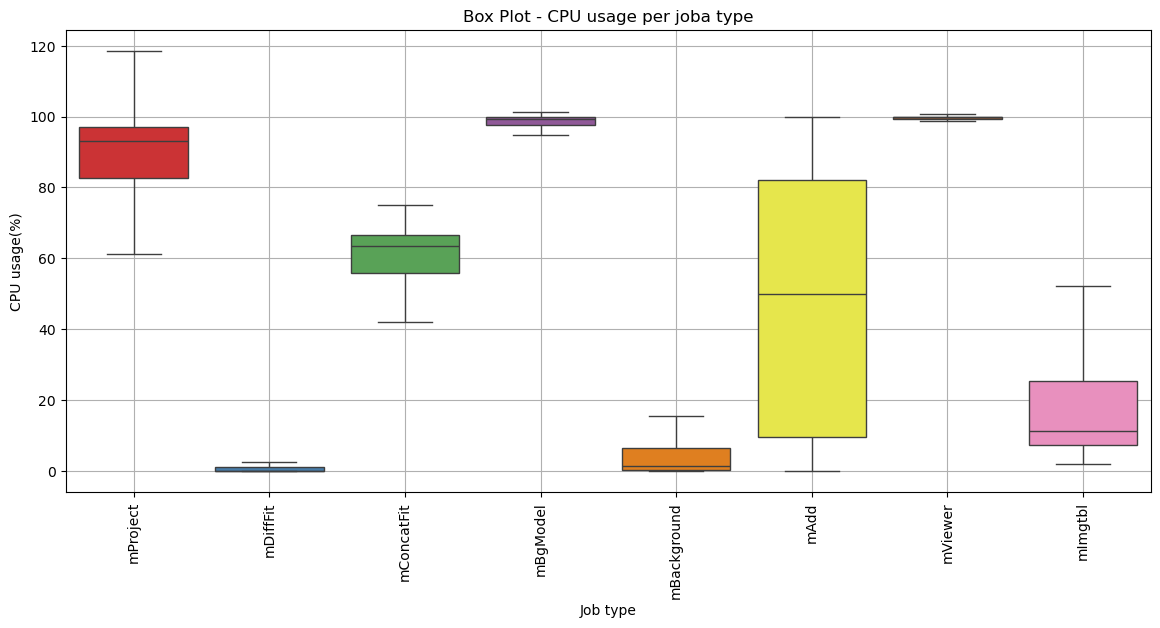

In [42]:
cpu_df = metrics_df[metrics_df['name'] == 'cpu-usage'].copy()
cpu_df['time'] = pd.to_datetime(cpu_df['time'], utc=True, errors='coerce')

job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()
cpu_df = cpu_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

plt.figure(figsize=(14, 6))
sns.boxplot(data=cpu_df, x='log.attributes.name', y='value', palette='Set1', showfliers=False)
plt.title("Box Plot - CPU usage per joba type")
plt.xlabel("Job type")
plt.ylabel("CPU usage(%)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Regression 
For job types that had more than 10 values

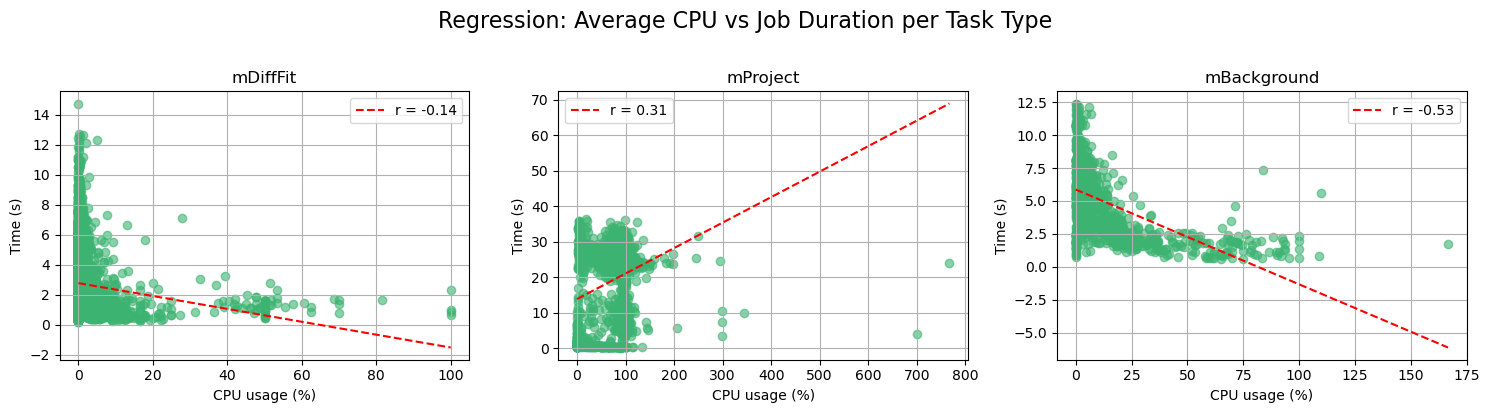

In [43]:
started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time']]
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']]
job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end'))
jobs['duration'] = (jobs['time_end'] - jobs['time_start']).dt.total_seconds()

cpu_df = metrics_df[metrics_df['name'] == 'cpu-usage'].copy()
cpu_per_job = cpu_df.groupby('metric.attributes.jobId')['value'].mean().reset_index()
cpu_per_job.rename(columns={'value': 'avg_cpu'}, inplace=True)

job_cpu_duration = pd.merge(jobs, cpu_per_job, left_on='log.attributes.jobId', right_on='metric.attributes.jobId')
job_cpu_duration = pd.merge(job_cpu_duration, job_types, on='log.attributes.jobId')
job_cpu_duration_clean = job_cpu_duration.dropna(subset=['avg_cpu', 'duration', 'log.attributes.name'])

valid_types = job_cpu_duration_clean['log.attributes.name'].value_counts()
valid_types = valid_types[valid_types >= 10].index.tolist()
filtered_data = job_cpu_duration_clean[job_cpu_duration_clean['log.attributes.name'].isin(valid_types)]

n_cols = 3
n_rows = int(np.ceil(len(valid_types) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False)

for idx, job_type in enumerate(valid_types):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    data = filtered_data[filtered_data['log.attributes.name'] == job_type]

    ax.scatter(data['avg_cpu'], data['duration'], color='mediumseagreen', alpha=0.6)

    # Regresja
    slope, intercept, r_value, p_value, std_err = linregress(data['avg_cpu'], data['duration'])
    line_x = np.linspace(data['avg_cpu'].min(), data['avg_cpu'].max(), 100)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color='red', linestyle='--', label=f'r = {r_value:.2f}')
    ax.legend()

    # Tytuł wykresu
    ax.set_title(str(job_type))
    ax.set_xlabel('CPU usage (%)')
    ax.set_ylabel('Time (s)')
    ax.grid(True)

# 6. Usuwanie pustych osi
for idx in range(len(valid_types), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    fig.delaxes(axes[row][col])

fig.suptitle("Regression: Average CPU vs Job Duration per Task Type", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Memory
### Statistics

In [44]:
memory_df = metrics_df[metrics_df['name'] == 'memory-usage'].copy()
job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()
memory_df = memory_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

memory_df['value_MB'] = memory_df['value'] / (1024 ** 2)
memory_per_job = memory_df.groupby(['metric.attributes.jobId', 'log.attributes.name'])['value_MB'].mean().reset_index()
memory_per_job.rename(columns={'value_MB': 'avg_memory_MB'}, inplace=True)

memory_grouped_stats = memory_per_job.groupby('log.attributes.name')['avg_memory_MB'].agg([
    ('Mean RAM usage (MB)', 'mean'),
    ('Min RAM (MB)', 'min'),
    ('Max RAM (MB)', 'max'),
    ('Job count', 'count'),
    ('P10 RAM (MB)', lambda x: x.quantile(0.10)),
    ('P25 RAM (MB)', lambda x: x.quantile(0.25)),
    ('P50 RAM (MB)', lambda x: x.quantile(0.50)),
    ('P90 RAM (MB)', lambda x: x.quantile(0.90)),
    ('P99 RAM (MB)', lambda x: x.quantile(0.99))
])

print(memory_grouped_stats)


                     Mean RAM usage (MB)  Min RAM (MB)  Max RAM (MB)  \
log.attributes.name                                                    
mAdd                           26.361659     26.036162     26.736654   
mBackground                    10.504783      0.000000     66.179688   
mBgModel                      133.578125    133.566406    133.597656   
mConcatFit                     66.925876     66.722111     67.099669   
mDiffFit                        0.785382      0.000000      5.174618   
mImgtbl                        67.302874     67.226562     67.409180   
mProject                        9.304500      0.000000     12.233946   
mViewer                      1860.367602   1815.094489   1932.446045   

                     Job count  P10 RAM (MB)  P25 RAM (MB)  P50 RAM (MB)  \
log.attributes.name                                                        
mAdd                         3     26.091362     26.174161     26.312160   
mBackground               1954      9.179557      9

### Histogram

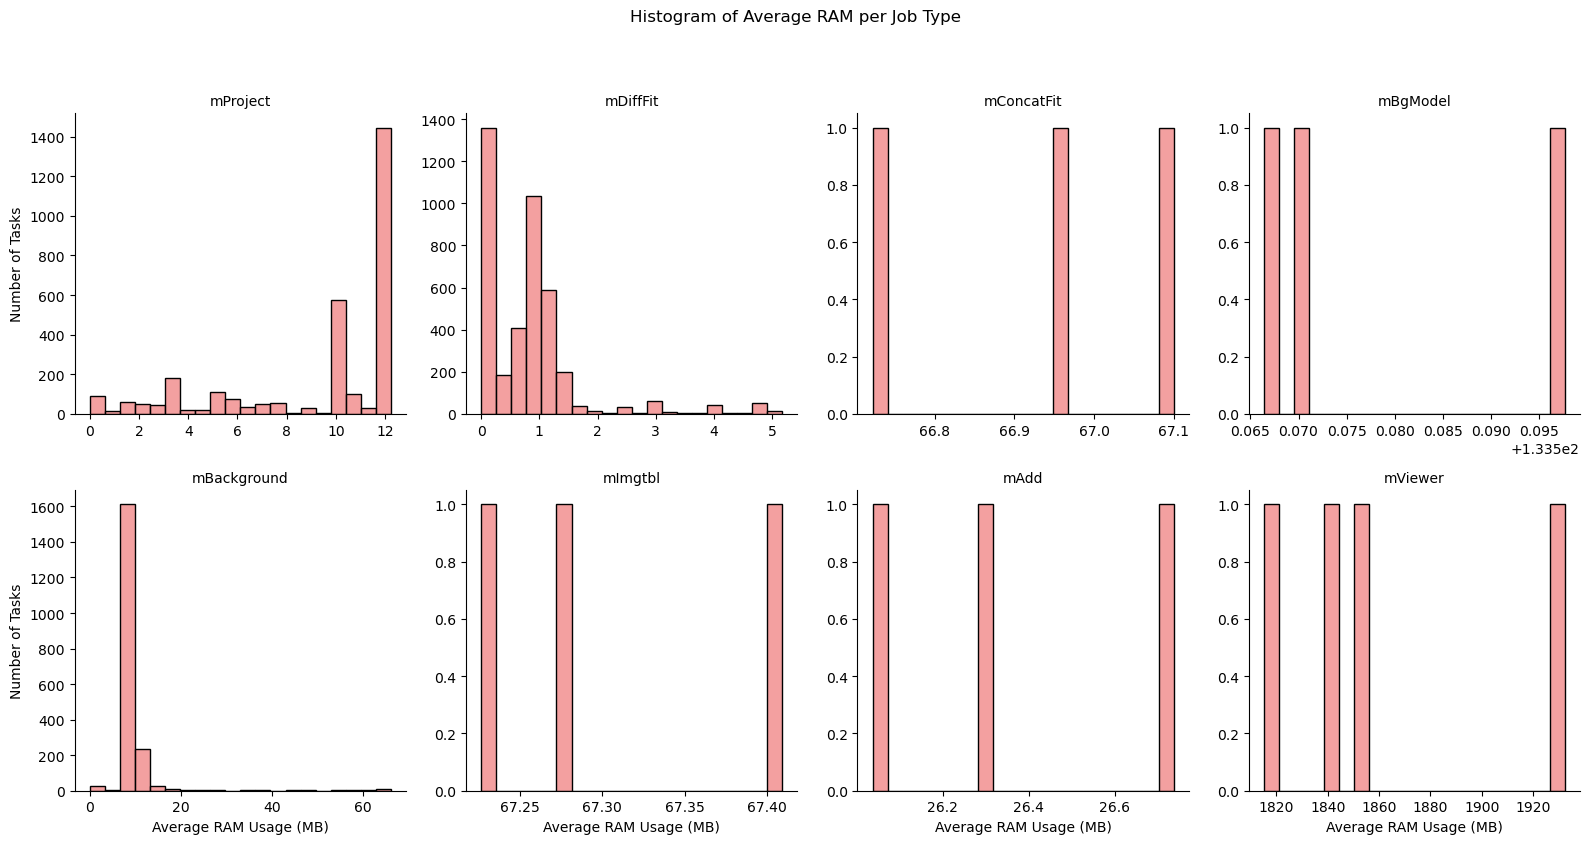

In [45]:
memory_df = metrics_df[metrics_df['name'] == 'memory-usage'].copy()
memory_df['time'] = pd.to_datetime(memory_df['time'], utc=True, errors='coerce')

memory_df = memory_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')
memory_per_job = memory_df.groupby(['metric.attributes.jobId', 'log.attributes.name'])['value'].mean().reset_index()
memory_per_job['avg_memory_MB'] = memory_per_job['value'] / (1024**2)

g = sns.FacetGrid(memory_per_job, col="log.attributes.name", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="avg_memory_MB", color='lightcoral', bins=20)
g.set_axis_labels("Average RAM Usage (MB)", "Number of Tasks")
g.set_titles(col_template="{col_name}")
plt.suptitle("Histogram of Average RAM per Job Type", y=1.05)
plt.tight_layout()
plt.show()


### Total of memory usage in time

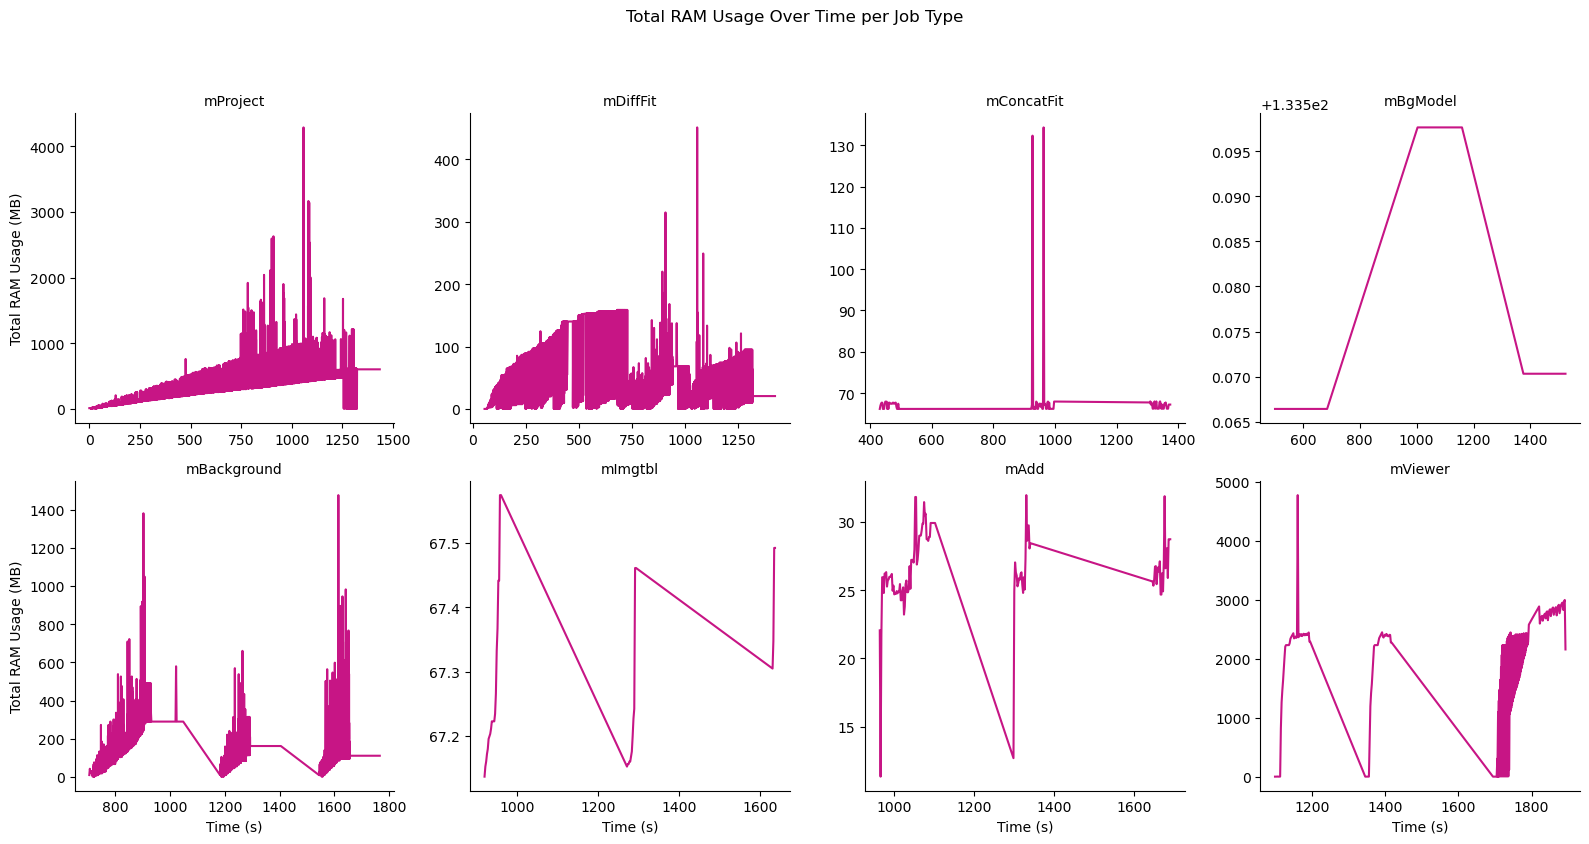

In [48]:
memory_df = metrics_df[metrics_df['name'] == 'memory-usage'].copy()
memory_df['time'] = pd.to_datetime(memory_df['time'], utc=True, errors='coerce')

memory_df = memory_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')

memory_grouped = memory_df.groupby(['time', 'log.attributes.name'])['value'].sum().reset_index()
memory_grouped['memory_MB'] = memory_grouped['value'] / (1024**2)

memory_start = memory_grouped['time'].min()
memory_grouped['time_seconds'] = (memory_grouped['time'] - memory_start).dt.total_seconds()

g = sns.FacetGrid(memory_grouped, col="log.attributes.name", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="time_seconds", y="memory_MB", color='mediumvioletred')
g.set_axis_labels("Time (s)", "Total RAM Usage (MB)")
g.set_titles(col_template="{col_name}")
plt.suptitle("Total RAM Usage Over Time per Job Type", y=1.05)
plt.tight_layout()
plt.show()


### Box plot

/var/folders/1c/3gp0dxs11_jbqbhcxmdbmf400000gn/T/ipykernel_37199/850125127.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=memory_df, x='log.attributes.name', y='memory_MB', palette='Set1', showfliers=False)


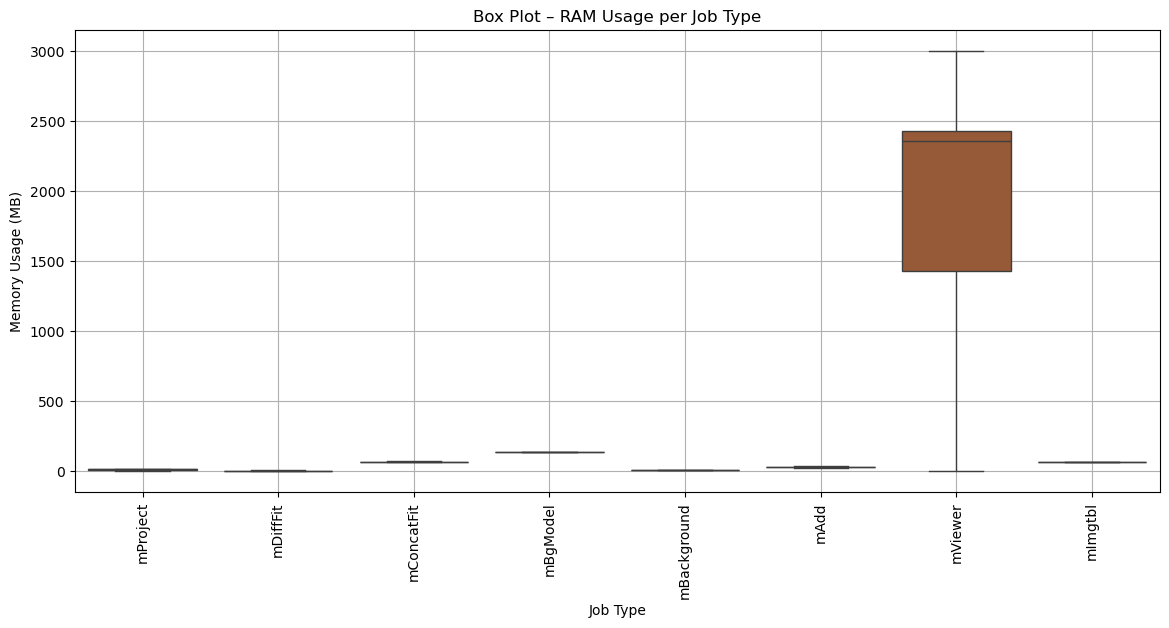

In [47]:
memory_df = metrics_df[metrics_df['name'] == 'memory-usage'].copy()
memory_df['time'] = pd.to_datetime(memory_df['time'], utc=True, errors='coerce')
memory_df = memory_df.merge(job_types, left_on='metric.attributes.jobId', right_on='log.attributes.jobId', how='left')
memory_df['memory_MB'] = memory_df['value'] / (1024**2)

plt.figure(figsize=(14, 6))
sns.boxplot(data=memory_df, x='log.attributes.name', y='memory_MB', palette='Set1', showfliers=False)
plt.title("Box Plot – RAM Usage per Job Type")
plt.xlabel("Job Type")
plt.ylabel("Memory Usage (MB)")
# plt.yscale('log')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Regression

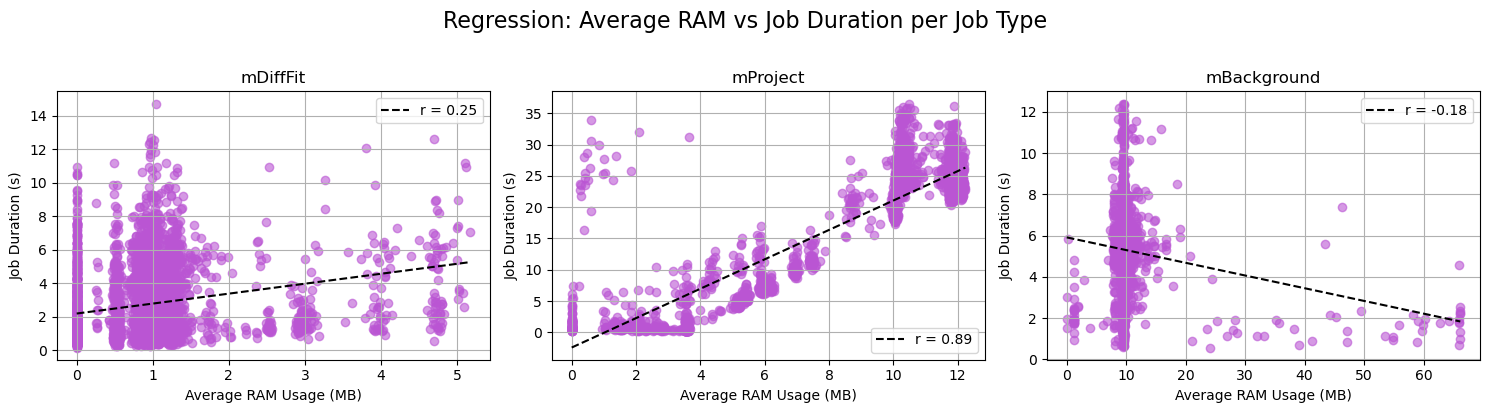

In [49]:

started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time']]
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']]
job_types = logs_df[['log.attributes.jobId', 'log.attributes.name']].drop_duplicates()

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end'))
jobs['duration'] = (jobs['time_end'] - jobs['time_start']).dt.total_seconds()

memory_df = metrics_df[metrics_df['name'] == 'memory-usage'].copy()
memory_df['time'] = pd.to_datetime(memory_df['time'], utc=True, errors='coerce')

memory_per_job = memory_df.groupby('metric.attributes.jobId')['value'].mean().reset_index()
memory_per_job.rename(columns={'value': 'avg_memory_bytes'}, inplace=True)
memory_per_job['avg_memory_MB'] = memory_per_job['avg_memory_bytes'] / (1024**2)

job_memory_duration = pd.merge(jobs, memory_per_job, left_on='log.attributes.jobId', right_on='metric.attributes.jobId')
job_memory_duration = pd.merge(job_memory_duration, job_types, on='log.attributes.jobId')
job_memory_duration_clean = job_memory_duration.dropna(subset=['avg_memory_MB', 'duration', 'log.attributes.name'])

valid_types = job_memory_duration_clean['log.attributes.name'].value_counts()
valid_types = valid_types[valid_types >= 10].index.tolist()
filtered_data = job_memory_duration_clean[job_memory_duration_clean['log.attributes.name'].isin(valid_types)]

n_cols = 3
n_rows = int(np.ceil(len(valid_types) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False)

for idx, job_type in enumerate(valid_types):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    data = filtered_data[filtered_data['log.attributes.name'] == job_type]

    ax.scatter(data['avg_memory_MB'], data['duration'], color='mediumorchid', alpha=0.6)

    slope, intercept, r_value, p_value, std_err = linregress(data['avg_memory_MB'], data['duration'])
    line_x = np.linspace(data['avg_memory_MB'].min(), data['avg_memory_MB'].max(), 100)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color='black', linestyle='--', label=f'r = {r_value:.2f}')
    ax.legend()

    ax.set_title(str(job_type))
    ax.set_xlabel("Average RAM Usage (MB)")
    ax.set_ylabel("Job Duration (s)")
    ax.grid(True)

for idx in range(len(valid_types), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    fig.delaxes(axes[row][col])

fig.suptitle("Regression: Average RAM vs Job Duration per Job Type", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## CPU and memory for selected jobs

SELECTED JOBS:

The longest:
- EG9126F8I-5-16444
- EG9126F8I-5-4779
- EG9126F8I-5-10260

Top CPU-heavy jobs:
- EG9126F8I-5-6003
- EG9126F8I-5-10976

Top RAM-heavy jobs:
- EG9126F8I-5-16443
- EG9126F8I-5-16444

The most common jobs:
- EG9126F8I-5-1
- EG9126F8I-5-4863
\Random jobs:
- EG9126F8I-5-7647
- EG9126F8I-5-6637


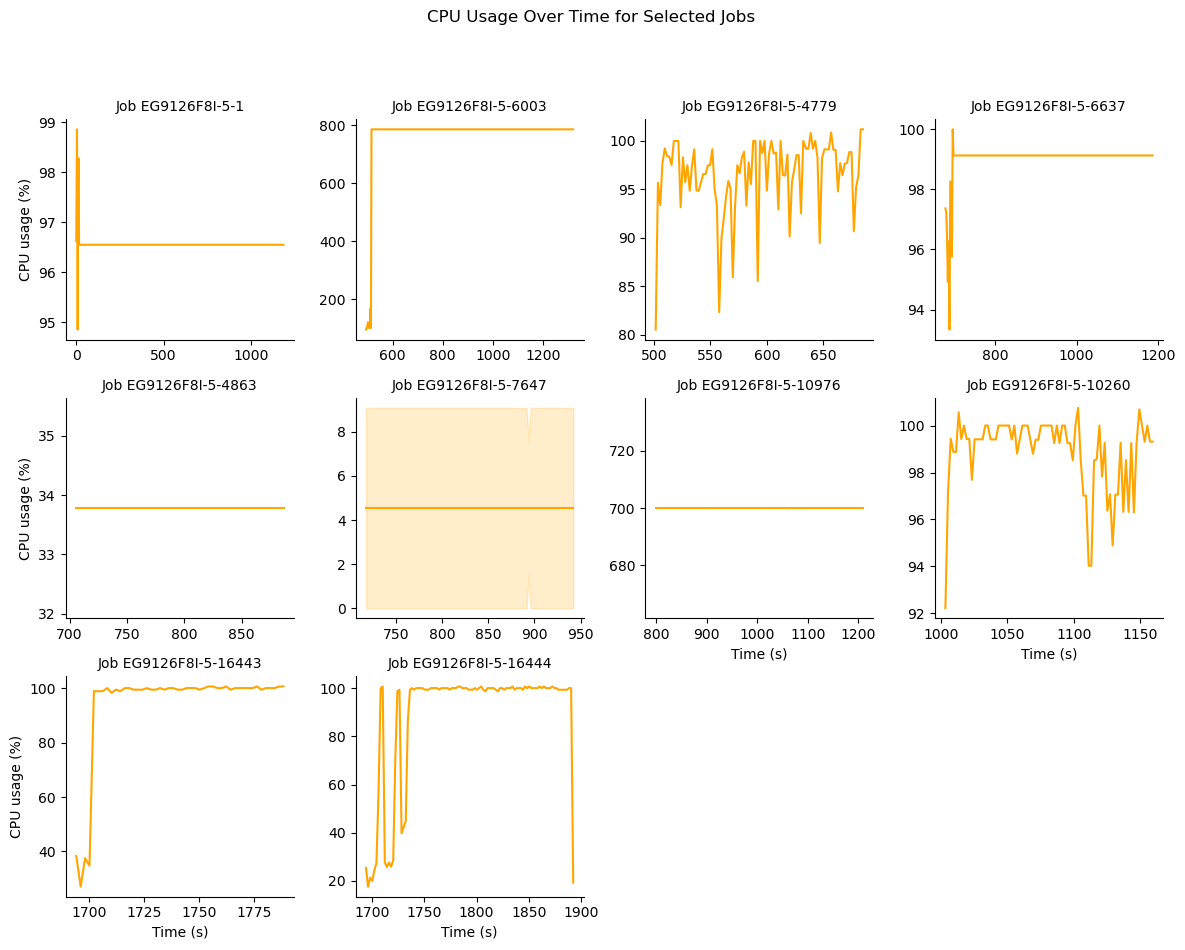

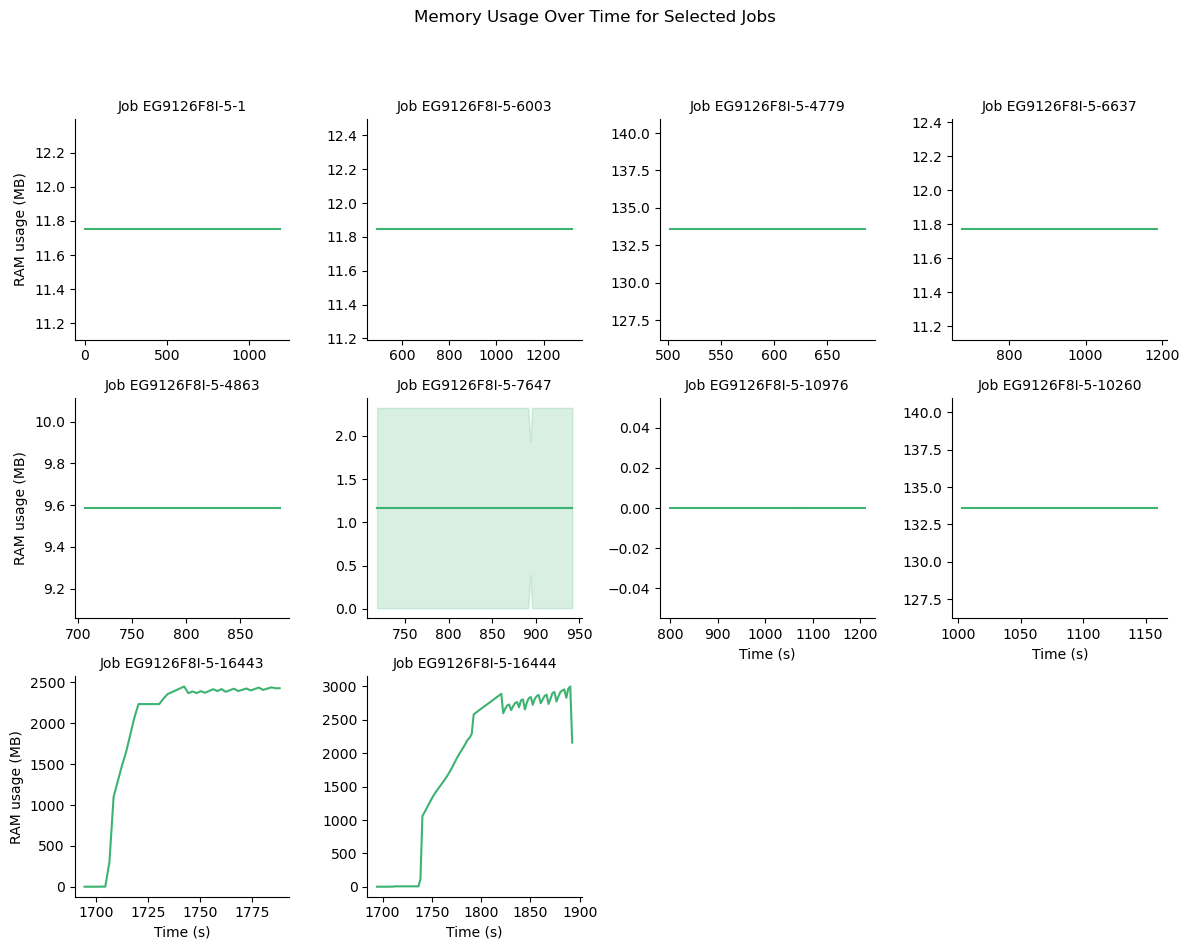

In [50]:
started = logs_df[logs_df['body'] == 'Job started'][['log.attributes.jobId', 'time', 'log.attributes.name']].copy()
ended = logs_df[logs_df['body'].str.contains('Job ended|Job finished', na=False)][['log.attributes.jobId', 'time']].copy()

started['time'] = pd.to_datetime(started['time'], utc=True, errors='coerce')
ended['time'] = pd.to_datetime(ended['time'], utc=True, errors='coerce')

jobs = pd.merge(started, ended, on='log.attributes.jobId', suffixes=('_start', '_end'))
jobs['duration'] = (jobs['time_end'] - jobs['time_start']).dt.total_seconds()


cpu_df['time'] = pd.to_datetime(cpu_df['time'], utc=True, errors='coerce')
memory_df['time'] = pd.to_datetime(memory_df['time'], utc=True, errors='coerce')

cpu_avg = cpu_df.groupby('metric.attributes.jobId')['value'].mean().reset_index()
memory_avg = memory_df.groupby('metric.attributes.jobId')['value'].mean().reset_index()

cpu_jobs_with_data = cpu_df['metric.attributes.jobId'].unique().tolist()
memory_jobs_with_data = memory_df['metric.attributes.jobId'].unique().tolist()
jobs_with_metrics_set = set(cpu_jobs_with_data) & set(memory_jobs_with_data)

# Najdłuższe joby
top_duration_jobs = jobs.sort_values('duration', ascending=False)['log.attributes.jobId'].tolist()
top_duration_jobs = [job for job in top_duration_jobs if job in jobs_with_metrics_set][:3]

# Top CPU-heavy
top_cpu_jobs = cpu_avg.sort_values('value', ascending=False)['metric.attributes.jobId'].tolist()
top_cpu_jobs = [job for job in top_cpu_jobs if job in jobs_with_metrics_set][:2]

# Top RAM-heavy
top_memory_jobs = memory_avg.sort_values('value', ascending=False)['metric.attributes.jobId'].tolist()
top_memory_jobs = [job for job in top_memory_jobs if job in jobs_with_metrics_set][:2]

# Najczęstsze typy
top_types = jobs['log.attributes.name'].value_counts().head(3).index.tolist()
top_type_jobs = jobs[jobs['log.attributes.name'].isin(top_types)] \
    .drop_duplicates('log.attributes.name')['log.attributes.jobId'].tolist()
top_type_jobs = [job for job in top_type_jobs if job in jobs_with_metrics_set]

# Losowe
already_selected = set(top_duration_jobs + top_cpu_jobs + top_memory_jobs + top_type_jobs)
available_for_random = list(jobs_with_metrics_set - already_selected)
random_jobs = np.random.choice(available_for_random, size=min(2, len(available_for_random)), replace=False).tolist()

selected_jobs = list(already_selected.union(random_jobs))

print("SELECTED JOBS:")

print("\nThe longest:")
for job in top_duration_jobs: print("-", job)

print("\nTop CPU-heavy jobs:")
for job in top_cpu_jobs: print("-", job)

print("\nTop RAM-heavy jobs:")
for job in top_memory_jobs: print("-", job)

print("\nThe most common jobs:")
for job in top_type_jobs: print("-", job)

print("\Random jobs:")
for job in random_jobs: print("-", job)

# === CPU Usage ===

cpu_selected = cpu_df[cpu_df['metric.attributes.jobId'].isin(selected_jobs)].copy()
cpu_start = cpu_selected['time'].min()
cpu_selected['time_seconds'] = (cpu_selected['time'] - cpu_start).dt.total_seconds()

g = sns.FacetGrid(cpu_selected, col="metric.attributes.jobId", col_wrap=4, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="time_seconds", y="value", color='orange')

g.set_axis_labels("Time (s)", "CPU usage (%)")
g.set_titles(col_template="Job {col_name}")
plt.suptitle("CPU Usage Over Time for Selected Jobs", y=1.05)
plt.tight_layout()
plt.show()

# === RAM Usage ===

memory_selected = memory_df[memory_df['metric.attributes.jobId'].isin(selected_jobs)].copy()
memory_selected['memory_MB'] = memory_selected['value'] / (1024**2)
memory_start = memory_selected['time'].min()
memory_selected['time_seconds'] = (memory_selected['time'] - memory_start).dt.total_seconds()

g = sns.FacetGrid(memory_selected, col="metric.attributes.jobId", col_wrap=4, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="time_seconds", y="memory_MB", color='mediumseagreen')

g.set_axis_labels("Time (s)", "RAM usage (MB)")
g.set_titles(col_template="Job {col_name}")
plt.suptitle("Memory Usage Over Time for Selected Jobs", y=1.05)
plt.tight_layout()
plt.show()


## IO info

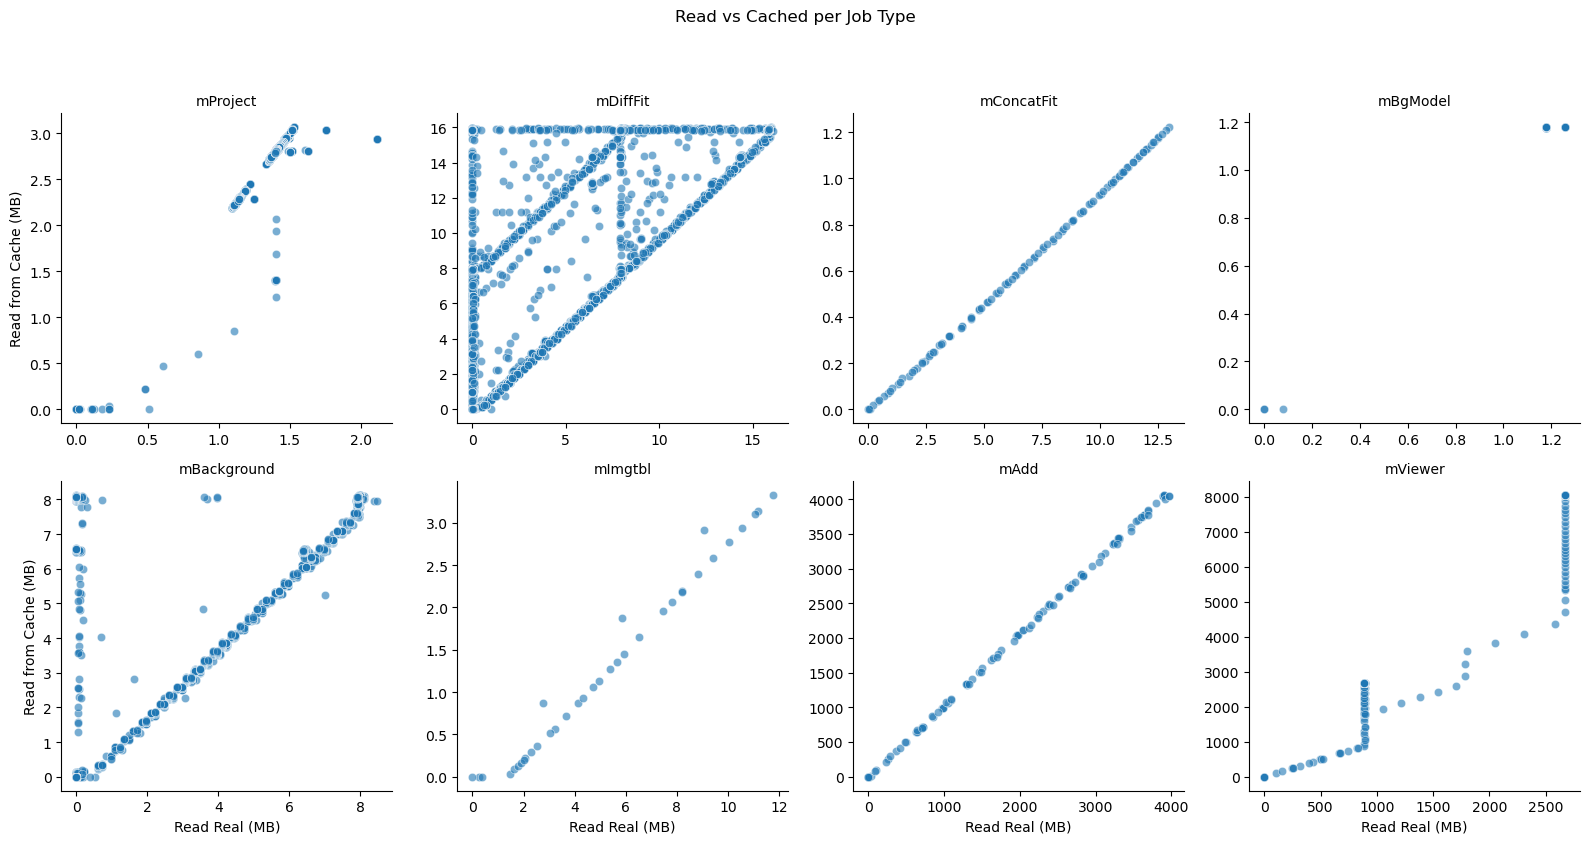

In [51]:
io_logs = logs_df[logs_df['body'] == 'IO info'].copy()

def parse_io_with_name(row):
    try:
        io_data = json.loads(row.get('log.attributes.io', '{}'))
        return pd.Series({
            'jobId': row.get('log.attributes.jobId'),
            'name': row.get('log.attributes.name'),
            'read': io_data.get('read', 0),
            'readReal': io_data.get('readReal', 0)
        })
    except:
        return pd.Series()

io_info_colored = io_logs.apply(parse_io_with_name, axis=1).dropna(subset=['read', 'readReal', 'name'])

io_info_colored['read'] = pd.to_numeric(io_info_colored['read'], errors='coerce')
io_info_colored['readReal'] = pd.to_numeric(io_info_colored['readReal'], errors='coerce')
io_info_colored['read_cached'] = io_info_colored['read'] - io_info_colored['readReal']
io_info_colored['readReal_MB'] = io_info_colored['readReal'] / (1024**2)
io_info_colored['read_MB'] = io_info_colored['read'] / (1024**2)
io_info_colored['read_cached_MB'] = io_info_colored['read_cached'] / (1024**2)


g = sns.FacetGrid(io_info_colored, col='name', col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='readReal_MB', y='read_MB', alpha=0.6)
g.set_axis_labels("Read Real (MB)", "Read from Cache (MB)")
g.set_titles("{col_name}")
plt.suptitle("Read vs Cached per Job Type", y=1.05)
plt.tight_layout()
plt.show()

## Queues and replicas

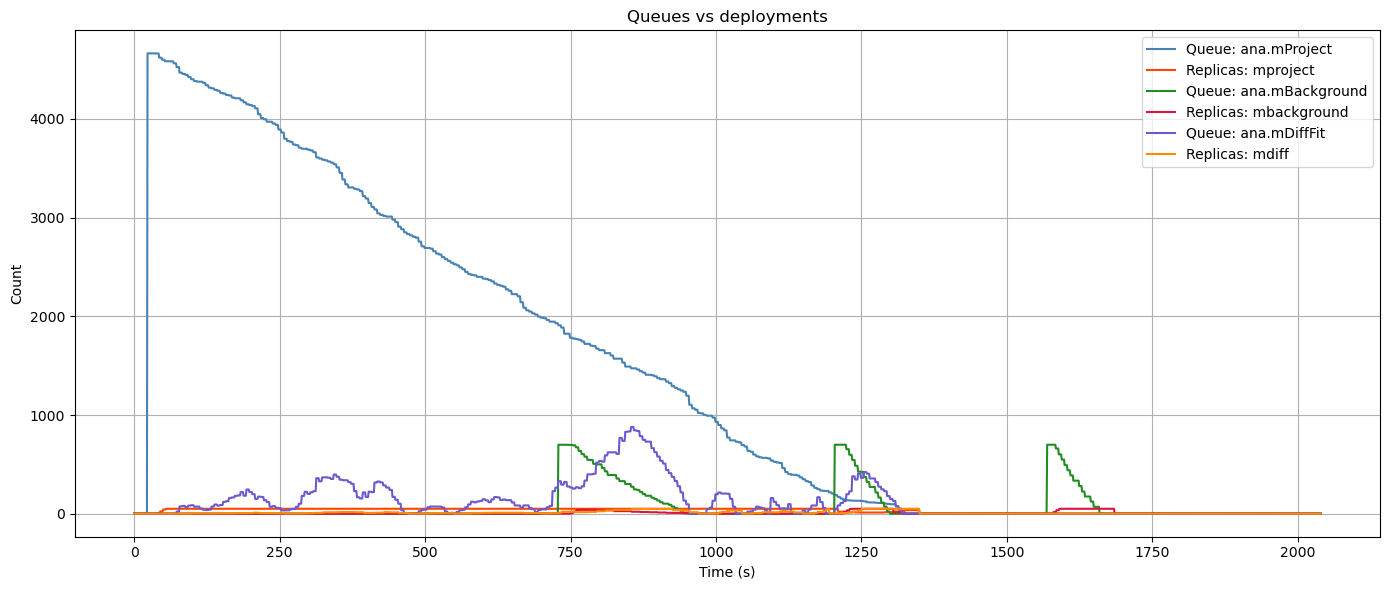

In [52]:
plt.figure(figsize=(14, 6))

# Provide mapping for queues and replicas
configs = [
    ('ana.mProject', 'mproject'),
    ('ana.mBackground', 'mbackground'),
    ('ana.mDiffFit', 'mdiff')
]
queue_df = metrics_df[metrics_df['name'] == 'rabbitmq_queue_messages_ready'].copy()
replicas_df = metrics_df[metrics_df['name'] == 'hyperflow_deployment_status_replicas_available'].copy()

queue_df['time'] = pd.to_datetime(queue_df['time'], utc=True, errors='coerce')

colors = ['steelblue', 'orangered', 'forestgreen', 'crimson', 'slateblue', 'darkorange']

for i, (queue_name, deployment_name) in enumerate(configs):
    queue_mbg = queue_df[queue_df['metric.attributes.queue'] == queue_name].copy()
    replicas_mbg = replicas_df[replicas_df['metric.attributes.deployment'] == deployment_name].copy()

    queue_mbg['time'] = pd.to_datetime(queue_mbg['time'], utc=True, errors='coerce')
    replicas_mbg['time'] = pd.to_datetime(replicas_mbg['time'], utc=True, errors='coerce')

    start_time = min(queue_mbg['time'].min(), replicas_mbg['time'].min())
    queue_mbg['time_seconds'] = (queue_mbg['time'] - start_time).dt.total_seconds()
    replicas_mbg['time_seconds'] = (replicas_mbg['time'] - start_time).dt.total_seconds()

    sns.lineplot(data=queue_mbg, x='time_seconds', y='value', 
                 label=f'Queue: {queue_name}', color=colors[i * 2])
    sns.lineplot(data=replicas_mbg, x='time_seconds', y='value', 
                 label=f'Replicas: {deployment_name}', color=colors[i * 2 + 1])

plt.xlabel("Time (s)")
plt.ylabel("Count")
plt.title("Queues vs deployments")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
